# UNET - Train on Fashion Dataset


This notebook shows how to train UNET on the Fashion dataset.

### The Dataset Object
This notebook will implement a Dataset object from the mcrnn implementation.  The dataset object holds a listing of all relevant data needed for training images and respective masks.  The object holds file references to the images and encoded masks for semantic segmentation.

The same dataset object used for training the MRCNN implementation is used in this workbook.  This helps to compare numerous implementation results by ensureing the same training data is used.

### UNET
UNET is a model that will produce a semantic segmentation based on an input image.  UNET acts as an encoder by using CNN's and Max Pooling to create an encoder and uses Upscaling and CNN's to decode.  UNET will output a sementaic segmentation of the same dimension as the input.  Each channel of the output is a binary mask for a segmentation class.  UNET's key feature is that the final output from each layer is concatenated with the corresponding layer on the decoding side.  The key feature allows the decoder to better represent more complex shape in the segmentation.  

### Limitations
#### Semantic Segmentation Only
UNET in its basic form will only output a semantic segmenation.  No boxing or instance identification is included.  This will increase the speed of training, but limits it use.

#### Fixed Dimensions
A UNET model is compiled with a fixed input dimension which drives a fixed output dimension.  Any training images or inferrence images will need to have the specificed input dimension.  MRCNN is more flexible and allows an input image of any size.


<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>



## Unet Architecture
![title](Unet_architecture.png)

### Setup local variables

In [1]:
import os, sys

project_root = "/Users/markmcdonald/Library/Mobile Documents/com~apple~CloudDocs/Harvard/CSCI_E25/Project/computer-vision-project"
data_dir     = '../../../data/FashionDataSet/'
train_dir    = os.path.join(data_dir, 'train')
images_file  = os.path.join(data_dir, 'train.csv' )
cat_file     = os.path.join(data_dir, 'label_descriptions.json' )
sys.path.append(project_root) # to capture FashtionDataset class
os.path.isdir(data_dir), os.path.isdir(train_dir), os.path.isfile(images_file), os.path.isfile(images_file)

(True, True, True, True)

## Set Backend For GPU Support
This can be commented out if an Nvidia GPU is being used or if processing is to be done using local CPUs

In [2]:
import os
# fix libiomp5.dylib error for mac
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# OPTIONAL SETTING
# Here we override the keras backend env variable to use plaidml
# plaidml can make use of AMD GPUs 
# This assignment needs to be added before loading keras libraries

# import plaidml
# import plaidml.keras
# plaidml.keras.install_backend()


os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"


# to install plaidML, activate appropriate environment and then:
#   pip install -U plaidml-keras
#   plaidml-setup


### Load Modules

In [52]:
# Keras imports

if os.environ.get("KERAS_BACKEND") == "plaidml.keras.backend":
    print("Loading PlaidML libraries for Keras.")
    import keras
    import keras.backend as K
    
    from keras.models import Model, load_model, model_from_json
    from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
    from keras.layers.core import Lambda, RepeatVector, Reshape
    from keras.layers.convolutional import Conv2D, Conv2DTranspose
    from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
    from keras.layers.merge import concatenate, add
    from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
    from keras.optimizers import Adam, SGD, RMSprop
    from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    from keras.utils import to_categorical, Sequence
    from keras.layers import UpSampling2D
    from keras.preprocessing import image
#     from keras.applications.resnet_v2 import ResNet152V2
    

else:
    print("Loading Tensorflow libraries for Keras.")
    import tensorflow as tf
    import tensorflow.keras.backend as K

    from tensorflow.python.keras.models import Model, load_model, model_from_json
    from tensorflow.python.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
    from tensorflow.python.keras.layers.core import Lambda, RepeatVector, Reshape
    from tensorflow.python.keras.layers.convolutional import Conv2D, Conv2DTranspose
    from tensorflow.python.keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
    from tensorflow.python.keras.layers.merge import concatenate, add
    from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
    from tensorflow.python.keras.optimizers import Adam, SGD
    from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    from tensorflow.python.keras.utils import to_categorical, Sequence
    from tensorflow.python.keras.layers import UpSampling2D
    from tensorflow.python.keras.preprocessing import image
#     from tensorflow.python.keras.applications.resnet_v2 import ResNet152V2
    

Loading PlaidML libraries for Keras.


In [4]:
import warnings
warnings.filterwarnings('ignore')

import datetime, os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import seaborn as sns

# import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)

from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import skimage
import random
from sklearn.model_selection import train_test_split
import pickle
from skimage.transform import resize

import FashionUtils.FashionDataset as FashionDataset #import FashionDataset, create_datasets, load_dataset, save_dataset

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# from mrcnn.model import log
from mrcnn.visualize import display_images

%matplotlib inline 

### Load FasionDataset Objects
If you have saved the datasets, you can load them, it resplit and build them again.

In [5]:
# # NOTE: There are 300k line images in the full training list
# fash_train, fash_val = FashionDataset.create_datasets( images_file=images_file, 
#                                         cat_file=cat_file,
#                                         images_dir=train_dir,
#                                         split=0.95, 
#                                         limit=150000)

# FashionDataset.save_dataset(fash_train, os.path.join(data_dir, 'fashion_train_dataset_150k.pkl'))
# FashionDataset.save_dataset(fash_val,   os.path.join(data_dir, 'fashion_val_dataset_150k.pkl'))

In [6]:
fash_train = FashionDataset.load_dataset(os.path.join(data_dir, 'fashion_train_dataset_150k.pkl'))
fash_val   = FashionDataset.load_dataset(os.path.join(data_dir, 'fashion_val_dataset_150k.pkl'))

../../../data/FashionDataSet/fashion_train_dataset_150k.pkl
../../../data/FashionDataSet/fashion_val_dataset_150k.pkl


In [7]:
im_height = 128 # must be power of 2
im_width = 128  # must be power of 2
im_channels = 3 # must be 3
im_shape = (im_height, im_width, im_channels)
n_classes = len(fash_train.class_ids)

In [50]:
# U-Net architecture
def UNet(input_img, 
         bn_enc:bool=False, 
         bn_dec:bool=True,
         contatenate:bool=True,
         init:str='glorot_uniform',
         activation='relu'): #keras.layers.ELU(alpha=1.0) keras.layers.LeakyReLU(alpha=0.3)

    def enc_layer(input_layer, depth, a=activation, i=init, p='same', bn=bn_enc):
        
        layer = Conv2D(depth, (3,3), padding=p, kernel_initializer = i)(input_layer)
        if bn:
            layer = BatchNormalization()(layer)
        layer = Activation(a)(layer)
        
        layer = Conv2D(depth, (3,3), padding=p, kernel_initializer = i)(input_layer)
        if bn:
            layer = BatchNormalization()(layer)
        layer = Activation(a)(layer)

        return MaxPooling2D(pool_size=(2,2))(layer), layer
    
    def dec_layer(input_layer, conc_layer, depth, a=activation, i=init, p='same', bn=bn_dec):
        
        layer = UpSampling2D((2,2))(input_layer)
        if concatenate:
            layer = concatenate([conc_layer,layer], axis=3)
        layer = Conv2D(depth, (3,3),padding=p,kernel_initializer = i)(layer)
        if bn:
            layer = BatchNormalization()(layer)
        layer = Activation(a)(layer)
        
        layer = Conv2D(depth, (3,3),padding=p,kernel_initializer = i)(layer)
        if bn:
            layer = BatchNormalization()(layer)
        layer = Activation(a)(layer)

        return layer
            

    # Encoder
    enc1_pool, enc1 = enc_layer(input_img,  64)
    enc2_pool, enc2 = enc_layer(enc1_pool, 128)
    enc3_pool, enc3 = enc_layer(enc2_pool, 256)
    enc4_pool, enc4 = enc_layer(enc3_pool, 512)
    
    encoder = Conv2D(1024, (3,3), padding='same', kernel_initializer = init)(enc4_pool)
    encoder = BatchNormalization()(encoder)
    encoder = Activation(activation)(encoder)
    encoder = Conv2D(512, (3,3), activation=activation, padding='same', kernel_initializer = init)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Activation(activation)(encoder)

    # Decoder
    dec4 = dec_layer(encoder, enc4, 512)
    dec3 = dec_layer(dec4,    enc3, 256) 
    dec2 = dec_layer(dec3,    enc2, 128)
    dec1 = dec_layer(dec2,    enc1, 64)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(dec1)
    print("outputs shape: ", outputs.shape)
    
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

### Generators for Images and Masks

In [158]:
class ImgMask_sequencer(Sequence):
    """
    Create batch generator based on Dataset object.
    Returns images and masks resize to target_size provided.
    """

    def __init__(self, dataset, 
                 batch_size:int=32, 
                 name:str=None, 
                 target_shape:tuple=(512,512,3),
                 color:bool=True):

        self.dataset      = dataset
        self.batch_size   = batch_size
        self.length       = len(self.dataset)
        self.num_batches  = int(np.floor(self.length / self.batch_size)) # no odd lots
        self.name         = name
        self.target_shape = target_shape
        self.classes      = self.dataset.source_class_ids['imaterialist']
        self.num_classes  = len(self.classes)
        self.color        = color
        self.train        = train

        print("Creating Generator '{}':".format(self.name))
        print("\tbatch size  : ", self.batch_size)
        print("\tlength      : ", self.length)
        print("\tnum batches : ", self.num_batches)
        print("\ttarget shape: ", self.target_shape)
        print("\tcolor       : ", self.color)
        
    def __len__(self):
        return self.num_batches
    
    def __iter__(self):
        batch_num = 0
        while true:
            i_batch, m_batch = self.__get_item__(batch_num)
            batch_num += 1
            if batch_num > self.num_batches-1:
                batch_num = 0
        yield i_batch, m_batch
    
    def __getitem__(self, idx):

        img_ids    = self.dataset.image_ids
       
        # get batch_num number of entries from dataset
        images, masks = [], []
        start = self.batch_size * idx
        end   = self.batch_size * (idx+1)
        
        if end>self.length-1:
            end = self.length-1

        for i in img_ids[start:end]:
            #load image and mask
            img  = self.dataset.load_image(i)
            mask, mask_classes = self.dataset.load_mask(i)
            
            # consider using modellib method
#             img, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset, config, image_id, augment=True, use_mini_mask=True)
#             mask = utils.expand_mask(bbox, mask, img.shape)
            
            # convert color
            if not self.color:
                img = np.mean(img, axis=2)
                img = np.stack([img for i in range(3)], axis=2) # make 3-channel bw image
            
            if self.target_shape != None:
                # cropping to centermost area is critical
                # padded bars to fill square crop does not train
                
                # get max size centered square crop
                x_side, y_side, _ = img.shape
                if x_side < y_side:
                    y_min = int((y_side-x_side)/2)
                    img  = img [ : , y_min:y_min+x_side , :]
                    mask = mask[ : , y_min:y_min+x_side , :]
                if x_side > y_side:
                    x_min = int((x_side-y_side)/2)
                    img  = img [x_min:x_min+y_side , : , :]
                    mask = mask[x_min:x_min+y_side , : , :]
                # else x_dim==y_dim and is already square
                
                # resize with boxes to maintain scale
                img, window, scale, padding, crop  = utils.resize_image(img, max_dim=self.target_shape[0], mode='square')
                mask = utils.resize_mask(mask, scale, padding, crop) # resize to match image - input shape

                # crop tile in center of image and mask
                x = int((img.shape[0]-self.target_shape[0])/2)
                y = int((img.shape[1]-self.target_shape[1])/2)
                img = img[x:x+self.target_shape[0], y:y+self.target_shape[1]]
                mask = mask[x:x+self.target_shape[0], y:y+self.target_shape[1]]
                
            else:
                self.target_shape = img.shape

            # create stacked mask
            stacked_mask = np.zeros(shape=(self.target_shape[0], self.target_shape[1], self.num_classes))
            try:
                stacked_mask[:,:,mask_classes] = mask
            except Exception as e:
                print("\nError on image number: {}".format(i))
                print(e)
                continue
            
            # if there are two instances of same class - merge layers   
            cl_unique, cl_counts = np.unique(mask_classes, return_counts=True)
            dup_classes = cl_unique[cl_counts>1]
            if len(dup_classes) > 0:
                for d in dup_classes:
                    locations = np.where(mask_classes==d)[0]
                    stacked_mask[:,:,d] = (np.sum(mask[:,:,locations],axis=2))>0

            images.append(img/255) # /255
            masks.append(stacked_mask)
            
        try:    
            img_stack  = np.stack(images, axis=0) 
            mask_stack = np.stack(masks, axis=0)
        except Exception as e:
            print("Image number: {}".format(i))
            print("Start: {}  End: {}".format(start, end))
            print(e)

        return (img_stack, mask_stack)
    

## Test Generator

In [191]:
def get_unstacked_mask(stacked_mask, threshold:float=0.5):
    """
    Return a mask with as many channels as there are classes.
    Also returns the class id's for the channels returned.
    """
    
    def get_classids(stacked_mask):
        # get class id's from stacked mask
        class_ids = []
        for c in range(stacked_mask.shape[2]):
            if np.max(stacked_mask[:,:,c])>threshold:
                class_ids.append(c)

        return np.array(class_ids).astype(int)
    
    class_ids = get_classids(stacked_mask)
    unstacked_mask = stacked_mask[:,:,class_ids]
    
    return (unstacked_mask>threshold, class_ids)
    

Creating Generator 'Train Generator':
	batch size  :  1
	length      :  16452
	num batches :  16452
	target shape:  (128, 128)
	color       :  True


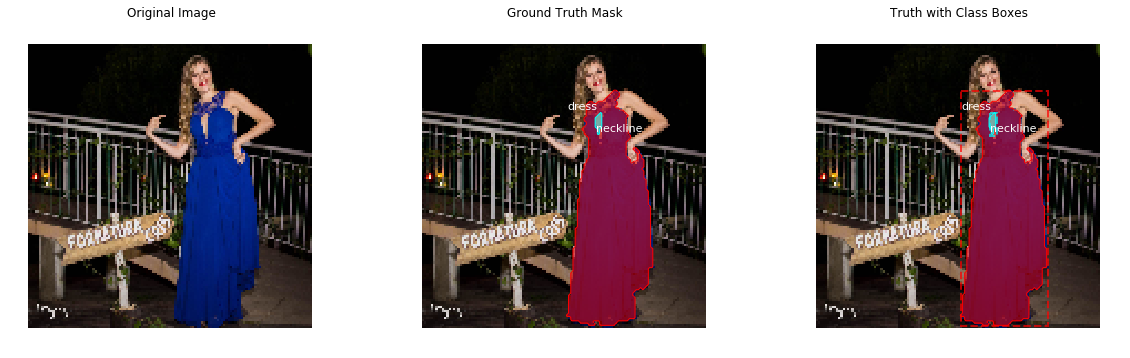

In [192]:
batch_size = 1
train_gen  = ImgMask_sequencer(fash_train, 
                                   batch_size=batch_size,
                                   name="Train Generator",
                                   target_shape=im_shape[0:2],
                                   color=True)

fix, ax = plt.subplots(ncols=3, figsize=(20,20), sharex=True, sharey=True)

rndidx = random.randint(0, len(fash_train))

test_image_batch, test_mask_batch = train_gen.__getitem__(rndidx)

test_image = test_image_batch[0]
test_mask  = test_mask_batch[0]

mask, class_ids = get_unstacked_mask(test_mask)
bbox = utils.extract_bboxes(mask)


ax[0].imshow(test_image)
ax[0].axis('off')
ax[0].set_title("Original Image")

visualize.display_instances(test_image*255, #*255
                            bbox, 
                            mask, 
                            class_ids, 
                            fash_val.class_names, 
                            figsize=(10,10),
                            show_bbox=False, show_mask=True,
                            ax=ax[1], title="Ground Truth Mask")

visualize.display_instances(test_image*255, #*255
                            bbox, 
                            mask, 
                            class_ids, 
                            fash_val.class_names, 
                            figsize=(10,10),
                            show_bbox=True, show_mask=True,
                            ax=ax[2], title="Truth with Class Boxes")



Test iterating through full dataset to emulate epoch

### Train Model

In [228]:
def train_unet(  model,
                 train_data,
                 val_data,
                 epochs=10,
                 target_shape:tuple=(512,512,3), 
                 batch_size:int=128,
                 log_dir:str="./logs",
                 color:bool=True,
                 optimizer=Adam(),
                 initial_epoch=1):
    
    # custom loss function IOU
    def iou_loss(actual, predicted) -> float:
        return np.sum(np.abs(actual-(predicted>.5)))
    
    # custom accuracy
    def iou_acc(actual, predicted) -> float:
        
        matches = K.count_params(K.equal(actual, predicted))
        size = K.prod(target_shape[0:2], axis=None, keepdims=False)
        
        return matches/size
    

    # Setup callbacks
    callbacks = [
        EarlyStopping(patience=3, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
        ModelCheckpoint(os.path.join(log_dir,'model-unet-fashion.h5'), verbose=1, save_best_only=True, save_weights_only=False),
        TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=batch_size, update_freq='batch')
    ]

    # Get generators for training and validation
    train_gen  = ImgMask_sequencer(train_data, 
                                   batch_size=batch_size,
                                   name="Train Generator",
                                   target_shape=target_shape[0:2],
                                   color=color)

    val_gen    = ImgMask_sequencer(val_data, 
                                   batch_size=batch_size,
                                   name="Val Generator",
                                   target_shape=target_shape[0:2],
                                   color=color)

    model.compile(optimizer=optimizer, 
                  loss="categorical_crossentropy", 
                  metrics=["acc"]) 

    results = model.fit_generator(  train_gen,  
                                    epochs=epochs,
                                    callbacks=callbacks, 
                                    validation_data=val_gen,
                                    shuffle=True,
                                    initial_epoch=initial_epoch)
    
    return results

In [165]:
logs_base_dir = os.path.join(data_dir, 'logs')
os.path.isdir(logs_base_dir)
log_dir=os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),"-2")

True

In [231]:

# model = UNet(Input(im_shape,name='img'), 
#                bn_enc=True, # should be off
#                bn_dec=True,  # should be on
#                init='glorot_uniform') #glorot_uniform he_normal
# model.load_weights('/Users/markmcdonald/Desktop/FashionDataSet/logs/20191210-115516/model-unet-fashion.h5')

In [ ]:
# Train Model
batch_size=4
epochs=4

# epochs
# 1 lr=.001, bs=2         # stalled at 7% 
# 2 lr=.010, bs=2         # stalled at 7%
# 3 lr=.010, bs=4         # climbed to 8.5%  1:08+:15
# 4 lr=.010, bs=8         # climbed to 10.8% 1:08+:15
# 5 SGD lr=.010/.99, bs=4 # dropped to 9.4%
# 6 RSMProp lr=.010, bs=4    # val acc:11%  ** stick with RSMProp
# 7 RSMProp lr=.020, bs=4    # val acc: 11.5%   train acc: 10.86%
# 8 RSMProp lr=.040, bs=4    # val acc: 11.96%  train acc: 11.37%
# 9 RSMProp lr=.050, bs=4   x2# val acc: 10.77%  train acc:11.69/12.25  %
# 10 RSMProp lr=.020, bs=4  x5# val_acc:13.83 train acc:15.82


history = train_unet(model,
                     fash_train,
                     fash_val,
                     epochs=epochs,
                     target_shape=im_shape, 
                     batch_size=batch_size,
                     log_dir=log_dir,
                     color=True,
                     initial_epoch=0, # 0 indexed values
                     optimizer=RMSprop(lr=.02)) #SGD(lr=.01, momentum=.99) RMSprop(lr=.01) Adam(lr=.01)

print("Training Complete.  Accuracy: {}".format(history.history['acc'][-1]))
model.save(os.path.join(log_dir,'model-unet-fashion-5epochs-batchsize4-lr02.h5'))


Creating Generator 'Train Generator':
	batch size  :  4
	length      :  16452
	num batches :  4113
	target shape:  (128, 128)
	color       :  True
Creating Generator 'Val Generator':
	batch size  :  4
	length      :  4113
	num batches :  1028
	target shape:  (128, 128)
	color       :  True
Epoch 1/4


INFO:plaidml:Analyzing Ops: 153 of 1888 operations complete
INFO:plaidml:Analyzing Ops: 309 of 1888 operations complete
INFO:plaidml:Analyzing Ops: 498 of 1888 operations complete
INFO:plaidml:Analyzing Ops: 571 of 1888 operations complete
INFO:plaidml:Analyzing Ops: 611 of 1888 operations complete
INFO:plaidml:Analyzing Ops: 795 of 1888 operations complete
INFO:plaidml:Analyzing Ops: 870 of 1888 operations complete


1608/4113 [==========>...................] - ETA: 48:39 - loss: 0.4684 - acc: 0.1598
Error on image number: 6136
shape mismatch: value array of shape (96,128,9) could not be broadcast to indexing result of shape (9,128,128)


INFO:plaidml:Analyzing Ops: 204 of 1888 operations complete
INFO:plaidml:Analyzing Ops: 462 of 1888 operations complete
INFO:plaidml:Analyzing Ops: 535 of 1888 operations complete
INFO:plaidml:Analyzing Ops: 610 of 1888 operations complete
INFO:plaidml:Analyzing Ops: 685 of 1888 operations complete
INFO:plaidml:Analyzing Ops: 869 of 1888 operations complete
INFO:plaidml:Analyzing Ops: 907 of 1888 operations complete


2254/4113 [===============>..............] - ETA: 36:45 - loss: 0.4718 - acc: 0.1583

Next:
> batch size to 8 -- 16 will kill kernel
> added shuffle to fit_generator()
> SGD()
> leakyrelu

Current:
> Current: softmax/categorical cross entropy
> Using batchsize of 5
> batch normalization up and down is off
> SGD(lr=.01, momentum=.99)
> removed he_normal ; back to glorot_uniform

Other:
> tried using simoid and binary_crossentropy - didn't work <br>
 it trained with high accuracies, but resulted in blobs and maxed out accuracy early<br>
> smaller batch sized prevent kernel crashes<br>
> tried different kernel initailization strtegies<br>
> tried different optimizations ; Adam, SGD(lr=.01, momentum=.99)<br>
> Dice loss is stated to help, but not a standard Keras loss function<br>
> updated sequenc generator for resizing issues and merged multiple instances into single layer<br>



In [279]:
model_save_dir = os.path.join(data_dir, 'logs')
model.save(os.path.join(model_save_dir,'model-unet-fashion-2epochs-batchsize4-Decent.h5'))

### Visualize Masks
Conver one-hot encoded masks into displayable masks

Creating Generator 'Train Generator':
	batch size  :  1
	length      :  4113
	num batches :  4113
	target shape:  (128, 128)
	color       :  True


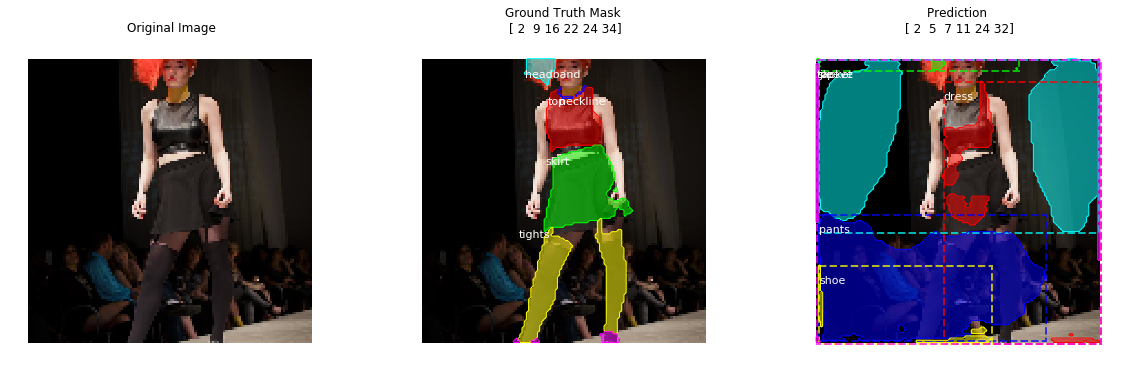

In [289]:
batch_size = 1
val_gen  = ImgMask_sequencer(  fash_val, 
                                 batch_size=batch_size,
                                 name="Train Generator",
                                 target_shape=im_shape[0:2],
                                 color=True)

rndidx = random.randint(0, len(fash_val))
test_image_batch, test_mask_batch = val_gen.__getitem__(rndidx)
test_image = test_image_batch[0]
test_mask  = test_mask_batch[0]

mask, class_ids = get_unstacked_mask(test_mask)
bbox = utils.extract_bboxes(mask)

fix, ax = plt.subplots(ncols=3, figsize=(20,20), sharex=True, sharey=True)

ax[0].imshow(test_image)
ax[0].axis('off')
ax[0].set_title("Original Image")

visualize.display_instances(test_image*255, 
                            bbox, 
                            mask, 
                            class_ids, 
                            fash_val.class_names, 
                            figsize=(10,10),
                            show_bbox=False, show_mask=True,
                            ax=ax[1], title="Ground Truth Mask \n{}".format(class_ids))

pred_mask_batch = model.predict(test_image_batch)
p_mask, p_class_ids = get_unstacked_mask(pred_mask_batch[0], threshold=0.5)
p_bbox = utils.extract_bboxes(p_mask)
visualize.display_instances(test_image*255, 
                            p_bbox, 
                            p_mask>.5, 
                            p_class_ids, 
                            fash_val.class_names, 
                            figsize=(10,10),
                            show_bbox=True, show_mask=True,
                            ax=ax[2], title="Prediction \n{}".format(p_class_ids))

